Erroneous pressure data

In [1]:
# imports
import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()
%matplotlib inline

import statsmodels.api as sm
import scipy.stats as stats

In [2]:
#constants
DATA_FOLDER_PATH = "data"

MAX_EXT = "Max.dat"
MIN_EXT = "Min.dat"

UPX_EXT = "UpX.dat"
DNX_EXT = "DnX.dat"

MEAN_EXT = "Mean.dat"
STD_EXT = "Std.dat"
LABELS_EXT = "Labels.dat"  # labels (broken, working and nil)

FILE_EXTENSIONS = {'max':MAX_EXT, 'min':MIN_EXT, 'upX':UPX_EXT, 'dnX':DNX_EXT,
          'mean':MEAN_EXT, 'std':STD_EXT, 'labels':LABELS_EXT}


TEST_DATA_NAME = "WC342"#"WB974"
t2 = "WD751T"

In [25]:
# load time trace data for pressure sensor
#TODO: put this into a single class for easy manipulation
def get_merged_table(flist, **kwargs):
    return pd.concat([pd.read_table(f, **kwargs) for f in flist], ignore_index=True)


def get_raw_data(folder, mask='/*.dat*', index_col=None):
    df = get_merged_table(glob.glob(folder + mask, recursive=True), skipinitialspace=True, index_col=None)
    return df


def load_data(folder, mask='*.dat*', index_col=None):    
    """ load data into dataframe """
    df = get_raw_data(folder, mask=mask, index_col=index_col)
    df = df[df['Tap_Id']!="NIL"]
    df.set_index('Tap_Id', inplace=True)
    
    try:
        df.drop(columns='Channel', inplace=True)
        df.columns = df.columns.astype(int)
    except KeyError: 
        # labels
        df['Broken Names'] = np.where(df['Status']=="BROKEN", df.index, "WORKING")
 
    
    return df


def load_dfs(data_path=None):
    if data_path is None:
        data_path = DATA_FOLDER_PATH
        masks = {key:"/*/*" + ext for key, ext in FILE_EXTENSIONS.items()}    
    else:
        masks = {key:"/*" + ext for key, ext in FILE_EXTENSIONS.items()}
    
    dfs = {}
    for key, mask in masks.items():
        dfs[key] = load_data(data_path, mask)

    return dfs
    

def load_test_dfs():
    return load_dfs(data_path=os.path.join(DATA_FOLDER_PATH, TEST_DATA_NAME))
    
dfs = load_test_dfs()
# TODO clean this up later

tmp_df = dfs['labels'].reset_index()
broken_idx = tmp_df[tmp_df["Status"]=="BROKEN"].index
print(broken_idx)
print(len(dfs['labels']))
#dfs['mean'].iloc[0]


Int64Index([115, 116, 117, 118, 262], dtype='int64')
301


Explore the data

In [13]:
def visalise(dfs, channel=0, ax=None):
    
    if ax is None:
        _, ax1 = plt.subplots(figsize=(12,12))
    else: 
        if isinstance(ax, gridspec.SubplotSpec):
            ax1 = plt.subplot(ax)
        else:
            ax1 = ax
    
    # second / parasite axis for standard deviation
    ax2 = ax1.twinx()

    keys = [('upX', 'g'), ('mean', 'b'), ('dnX', 'm')]
    
    # if channel is supplied
    title = f"tapID: {dfs['labels'].index[channel]} | status: {dfs['labels'].iloc[channel][0]}"
    ax1.set_title(title)
    
    for key, color in keys:
        ax1.plot(dfs[key].iloc[channel], label=key, color=color)

    ax2.plot(dfs['std'].iloc[channel], label=key, color='r')    
        
    ax1.set_xticks(np.arange(0,400,50))
    ax1.set_yticks(np.linspace(-1.5, 1.5, 9)) 
    ax2.set_yticks(np.linspace(0.0, 1.0, 9)) 
    
    ax1.axhline(0, ls='-', color='k', linewidth=2) 
    ax2.axhline(0.5, ls='-', color='k', linewidth=2) # have to plot on both axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # it looks better when i don't force the limits
    #ax1.set_xlim([0,350])
 
n = 4#len(broken_idx)
fig = plt.figure(figsize=(2*8 ,n*8))

gs = gridspec.GridSpec(n,2, fig, wspace = 0.5, hspace = 0.5)    
    
o = 0
b_ids = range(n)

for b_id in b_ids:
    visalise(dfs, channel=broken_idx[b_id+o], ax=gs[b_id,0])


for b_id in b_ids:
    # pltting some random taps
    visalise(dfs, channel=b_id+o, ax=gs[b_id,1])    

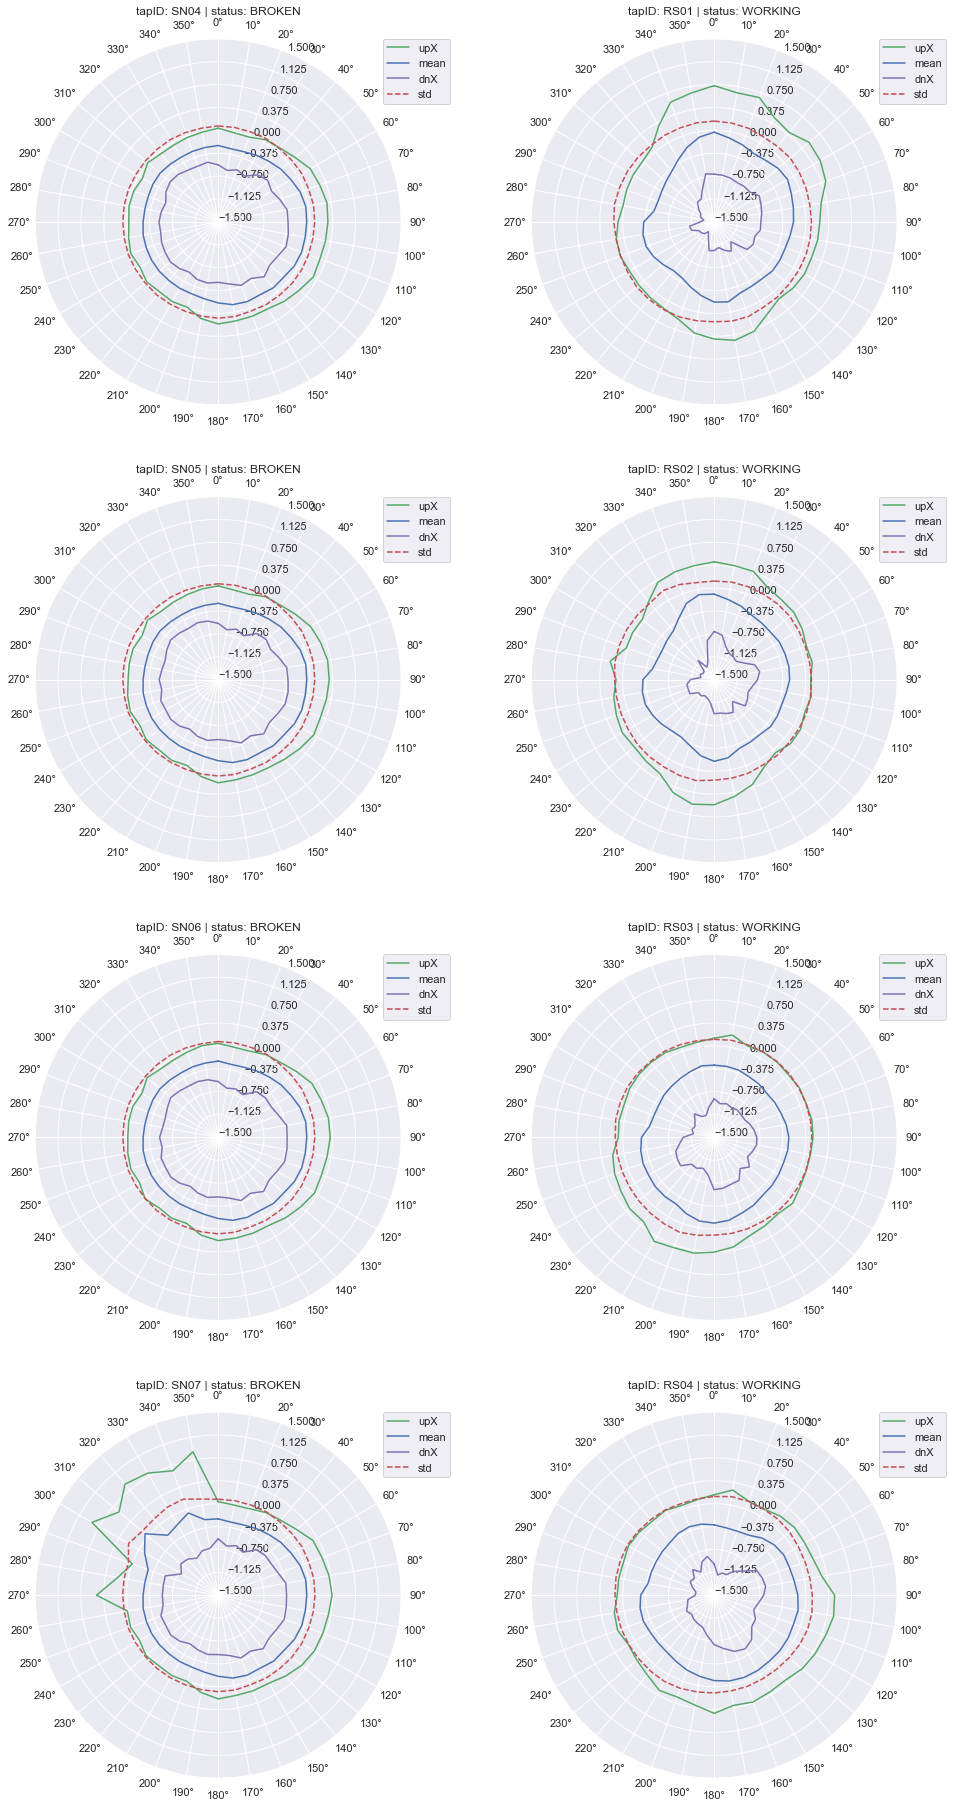

In [5]:
def visalise_polar(dfs, channel=0, ax=None):
    """ visualise the data in the polar coordinate system
    
    TODO: combine the two visualise functions into one
    TODO: handle the axis argument better. currently very messy and not clear what the user should do
    TODO: clean up the code holy fuck 
    
    """
    def _close_line(line):
        """ 
        helper function to close lines in polar plots 
        
        not sure where i originally saw this but i got it from one of my old scripts and don't think it's mine 
        """
        x, y = line.get_data()
        x = np.concatenate((x, [x[0]]))
        y = np.concatenate((y, [y[0]]))
        line.set_data(x, y)
    
    if ax is None:
        #TODO: clean this up
        _, ax1 = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
        
    else: 
        if isinstance(ax, gridspec.SubplotSpec):
            ax1 = plt.subplot(ax, projection='polar')
            
        else:
            ax1 = ax
    
    theta = np.pi/180. * np.linspace(0,  360, 36, endpoint=False)
    ax1.set_xticks(theta)
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi/2.0)

    keys = [('upX', 'g'), ('mean', 'b'), ('dnX', 'm')]
    

    title = f"tapID: {dfs['labels'].index[channel]} | status: {dfs['labels'].iloc[channel][0]}"
    ax1.set_title(title)

    for key, color in keys:
        line, = ax1.plot(theta, dfs[key].iloc[channel], label=key, color=color)
        _close_line(line)

    #TODO: twiny for polar plot
    line, = ax1.plot(theta, dfs['std'].iloc[channel], label='std', color='r', linestyle="--")
    _close_line(line)

        
    ax1.axhline(0, ls='-', color='k', linewidth=2) 
    ax1.set_yticks(np.linspace(-1.5, 1.5, 9))
    

    ax1.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
    
    
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), subplot_kw=dict(projection='polar'))
#visalise_polar(dfs, channel=0, tap_id=None, ax=ax1)        
#visalise_polar(dfs, channel=55, tap_id=None, ax=ax2)   


n = 4# len(broken_idx)
fig = plt.figure(figsize=(2*8 ,n*8))

gs = gridspec.GridSpec(n,2, fig, wspace = 0.25, hspace = 0.25)    
    
o = 0
b_ids = range(n)

for b_id in b_ids:
    visalise_polar(dfs, channel=broken_idx[b_id+o], ax=gs[b_id,0])

for b_id in b_ids:
    visalise_polar(dfs, channel=b_id+o, ax=gs[b_id,1])    

Explore the broken taps



In [6]:
print(broken_idx)

def visualise_sensor(dfs, channel=None, tap_id=None, figsize=(16,8)):
    """ combine the two visualisations into one axis """
    # TODO: handle tap_id passed and return multiple plots
    
    dfs
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1,2, fig, wspace = 0.25)    

    visalise(dfs, channel=channel, ax=gs[0,0])
    visalise_polar(dfs, channel=channel, ax=gs[0,1])    

Int64Index([115, 116, 117, 118, 262], dtype='int64')


In [7]:
broken_channel = broken_idx[6]

print(f"visualising {broken_channel}")
visualise_sensor(dfs, channel=broken_channel, figsize=(16,8))

IndexError: index 6 is out of bounds for axis 0 with size 5

The sensor seems to be broken for several angles. 

The sensor likely dislodged during testing. 

The signal seems disjointed: angles 90-150 and angles 0-10 seem similar, and angles 20-80 and 160-350 seem similar. 

This is due to the fact that this test had multiple terrain categories so the wind tunnel was tested with one upstream profile for some angles, and then stopped, and then the profile was changed, and the tunnel was restarted. 

It is likely that during the change of terrain category, the sensor was dislodged either from the model or on the collar that connects to the acquisition system.

In [ ]:
broken_channel = broken_idx[5]

print(f"visualising {broken_channel}")
visualise_sensor(dfs, channel=broken_channel, figsize=(16,8))

this doens't look very broken. I'll look at the sensors around it. wd01 and wd03

In [ ]:
next_channel = broken_channel - 1
visualise_sensor(dfs, channel=next_channel, figsize=(16,8))

In [ ]:
tap_id = "WD03"
print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

In [ ]:
tap_id = "WE02"
print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

Ok so WD02 seems very low compared to the sensors around it. It's probably worth noting that the reference ratio hasn't been applied to the data yet so the absolute values of this data doesn't mean very much. 

lets try another broken sensor EE01



In [ ]:
tap_id = broken_idx[3]

print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

this sensor seems to have a very low signal for all directions with a constant mean and constant variance. 

the upX, mean and dnX also seem very spikey comparing neighbouring angles. 

This indicates that the sensor may not have been disconnected before the test started. 

looking at the sensors next to ee01, namelye ee02, ef01, and ed01

In [ ]:
tap_id = "EF01"

print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

In [ ]:
tap_id = "ED01"

print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

the sensor ee01 is obviously broken

In [ ]:
tap_id = broken_idx[13]

print(f"visualising {tap_id}")
visualise_sensor(dfs, tap_id=tap_id, channel=None, figsize=(16,8))

This sensor has a strong mean response but does not seem to have a strong positive or negative deviation. 

This is indicative of a partially blocked sensor. A partially blocked sensor cannot fluctuate strongly and hence the peak positive and negative readings don't deviate from the mean. 

the low standard deviation in combination with the highly varying mean is a good indicator of this. 

# Discussion:

There have been 3 types of broken sensors discussed here. 

1. Sensor disconnected before the test started
2. Sensor disconnected during the test
3. Sensor partially blocked for the duration of the test

The indicators of these broken sensors have also been discussed

1. Very low signal with no variation in direction
2. high variance between neighbouring angles, std shift>1
3. Strong mean signal with low std

we can create features from the signals to use for classifying the sensor results
1. f1 = max(max(upX)-min(upX), max(mean)-min(mean), max(dnX)-min(dnX)) -> low result = broken
2. f2 = mean[t] - mean[t-1] -> high result = broken
3. f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken

In [ ]:
def create_features(dfs):
    # feature 1 
    max_upX = dfs['upX'].max(axis=1)
    min_upX = dfs['upX'].min(axis=1)

    max_dnX = dfs['dnX'].max(axis=1)
    min_dnX = dfs['dnX'].min(axis=1)

    max_mean = dfs['mean'].max(axis=1)
    min_mean = dfs['mean'].min(axis=1)

    f1 = pd.concat([max_upX-min_upX, max_dnX-min_dnX, max_mean-min_mean], axis=1).max(axis=1)
    
    mean_wrap = dfs['mean'].copy()
    mean_wrap[-10] = dfs['mean'][350].copy()
    mean_wrap[360] = dfs['mean'][0].copy()
    mean_wrap = mean_wrap.reindex(sorted(mean_wrap.columns), axis=1)
    
    f2 = (mean_wrap.shift(1, axis=1) - mean_wrap).max(axis=1)
    
    f3 = (dfs['upX']-dfs['dnX']).max(axis=1) / (max_mean-min_mean)
    features = pd.concat([dfs['labels']['Status'], f1, f2, f3], axis=1)
    features.columns=['Status', 'f1', 'f2', 'f3']
    
    return features
    
features_dfs = create_features(dfs)
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,12))
sns.distplot(features_dfs['f1'], norm_hist=True, vertical=False, ax=ax1) 
sns.distplot(features_dfs['f2'], norm_hist=True, vertical=False, ax=ax2) 
sns.distplot(features_dfs['f3'], norm_hist=True, vertical=False, ax=ax3) 
print(features_dfs.head())

## Comments
- feature 1 doesn't seem very good. there seems to be a lot of sensors lumped into the lowest bin. 
- feature 2 seems to work however that was the most obvious.  
- feature 3 seems to indicate that there are a few sensors in the lowest 3 bins

we shall explore them


In [ ]:
features_dfs.sort_values(by='f1').head(10)

feature 1 seems to have classified a lot of broken sensors but there doesn't seem to be a clear boundary.

The false positives seem to be mostly roof taps and taps close to the ground. 

This is the nature of the feature, "Very low signal with no variation in direction".

Roof taps don't have strong directionality as they never directly face the wind. 
Taps low to the ground are so shielded that they aren't exposed to the direct wind. 

#TODO: incorporate z coordinate of the sensor and normal direction from the CAD model 

In [ ]:
features_dfs.sort_values(by='f2').tail(10)

feature 2 correctly classified the 2 sensors that popped out. 

it also collected another broken sensor at the fringe, however this isn't clear. 

In [ ]:
visualise_sensor(dfs, tap_id="PWI06")

I didn't look at this particular sensor. 

This is clearly broken. It is extremely spikey and has strongly varying mean but relatively low variance. the difference in the upX and dnX seems constant across teh signal. 

I'm not sure what physical process has caused this. 

I hope this is detected in feature 3.

In [ ]:
features_dfs.sort_values(by='f3').head(10)

feature 3 seems to have captured the majority of broken taps. 

it seems to have mislabelled SQ01 as broken. 

In [ ]:
visualise_sensor(dfs, tap_id="SQ01")

the sensor seems fine. It has a feature 3 score of 1.189311

f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken

interpreting this 
max(upX-dnX) is the maximum difference between the peak positive and the peak negative. This is sort of proxy for std. 

(max(mean)-min(mean)) it the difference between the peak positive mean and peak negative mean. This is a sort of proxy for the directionality of the sensor. 

In this case, the sensor has a relatively large variation in mean. 

lets see if we can better classify the broken taps using the std instead of the proxy

f4 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken

i'll put it in a class for clarity and portability

         labels      f1      f2        f3        f4
Tap_Id                                             
NN07    WORKING  1.4205  0.1385  2.895341  6.691654
NS06    WORKING  1.1923  0.2658  3.936827  6.830582
NN02    WORKING  1.3206  0.2164  2.667964  7.323337
SJ01    WORKING  1.2786  0.2384  3.214050  7.551286
SP02    WORKING  1.1777  0.1924  2.357531  7.652299
NR04    WORKING  2.0494  0.1847  3.141874  7.661472
SH01    WORKING  1.3271  0.2162  3.367244  7.699970
NL08    WORKING  1.8212  0.1290  3.417565  7.729822
SL01    WORKING  1.4550  0.2338  2.977238  7.750351
WN03    WORKING  1.1363  0.2098  2.406592  7.761054


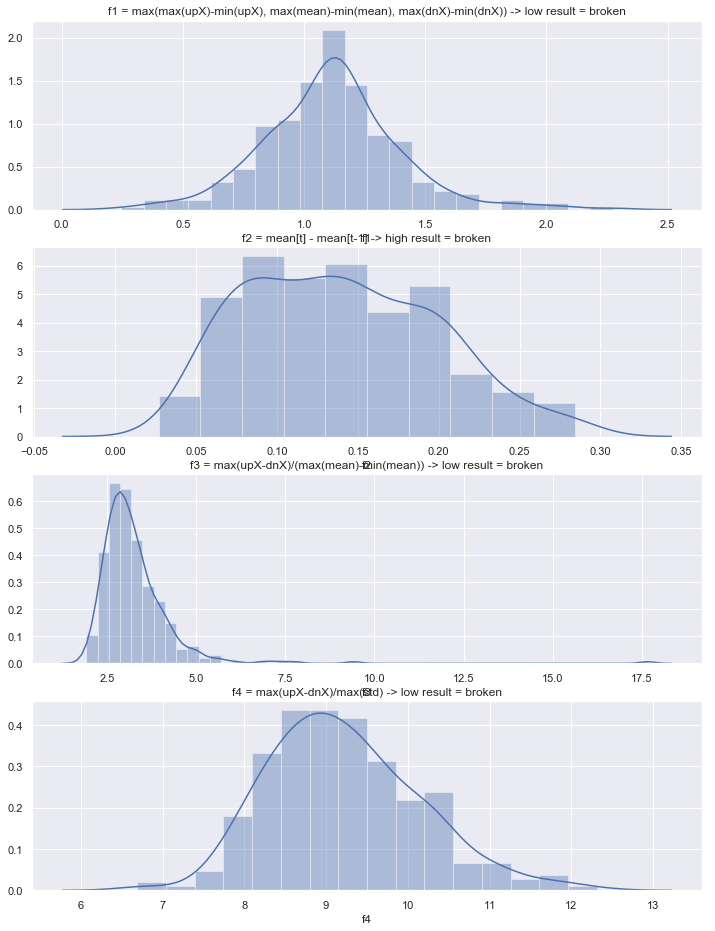

In [27]:
class Features(object):
    def __init__(self, dfs):
        self.dfs = dfs
        self.number_of_features = 4
        self.feature_labels = ['f1 = max(max(upX)-min(upX), max(mean)-min(mean), max(dnX)-min(dnX)) -> low result = broken', 
                      'f2 = mean[t] - mean[t-1] -> high result = broken', 
                      'f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken', 
                      'f4 = max(upX-dnX)/max(std) -> low result = broken']
        
        self.features = self.build_features()

    def plot(self, axs=None):
        if axs is None:
            _, axs = plt.subplots(self.number_of_features,1,figsize=(12, 4*self.number_of_features))
        columns = self.features.columns[1:]
        for i, ax in enumerate(axs):
            sns.distplot(self.features[columns[i]], norm_hist=True, vertical=False, ax=ax).set_title(self.feature_labels[i]) 
            
            
    def build_features(self):
        f1 = self.build_f1()
        f2 = self.build_f2()
        f3 = self.build_f3()
        f4 = self.build_f4()
        
        df = pd.concat([self.dfs["labels"]["Broken Names"], f1, f2, f3, f4], axis=1)
        df.columns = ["labels", "f1", "f2", "f3", "f4"]
        return df
        
        
    def build_f1(self):
        """
        f1 = max(max(upX)-min(upX), max(mean)-min(mean), max(dnX)-min(dnX)) -> low result = broken
        """
        max_upX = self.dfs['upX'].max(axis=1)
        min_upX = self.dfs['upX'].min(axis=1)

        max_dnX = self.dfs['dnX'].max(axis=1)
        min_dnX = self.dfs['dnX'].min(axis=1)

        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)

        f1 = pd.concat([max_upX-min_upX, max_dnX-min_dnX, max_mean-min_mean], axis=1).max(axis=1)
        return f1 
    
    
    def build_f2(self):
        """
        max sequential mean 
        f2 = mean[t] - mean[t-1] 
        
        high result = broken
        low result = broken
        """
        mean_wrap = self.dfs['mean'].copy()
        mean_wrap[-10] = self.dfs['mean'][350].copy()
        mean_wrap[360] = self.dfs['mean'][0].copy()
        mean_wrap = mean_wrap.reindex(sorted(mean_wrap.columns), axis=1)
        f2 = (mean_wrap.shift(1, axis=1) - mean_wrap).max(axis=1)
        return f2 
    
    
    def build_f3(self):
        """f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken"""
        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)
        f3 = (self.dfs['upX']-self.dfs['dnX']).max(axis=1) / (max_mean-min_mean)
        return f3 
    
    
    def build_f4(self):
        """f4 = max(upX-dnX)/(std.max()) -> low result = broken"""
        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)
        f4 = (self.dfs['upX']-self.dfs['dnX']).max(axis=1) / (self.dfs['std'].max(axis=1))
        return f4


features = Features(dfs)
features.plot()

print(features.features.sort_values(by='f4').head(10))

the modified feature 3 (feature 4) seems to have caught zb04 and eb04, both of which were caught by feature 2. 

lets try not normalising the feature at all and just look at max( upx-dnx)

AttributeError: Unknown property figsize

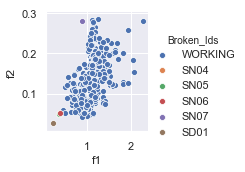

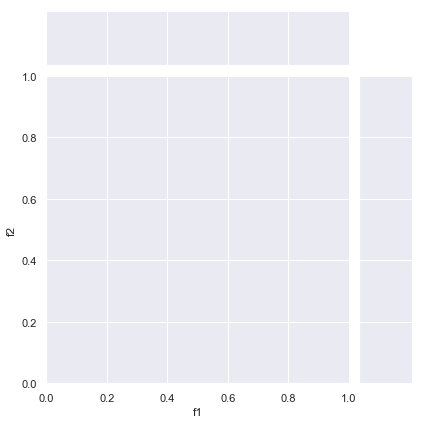

In [94]:
class Features(object):
    """
    Features object 
    """
    
    def __init__(self, dfs):
        self.dfs = dfs        
        self.feature_labels = ['f1 = max(max(upX)-min(upX), max(mean)-min(mean), max(dnX)-min(dnX)) -> low result = broken', 
                      'f2 = mean[t] - mean[t-1] -> high result = broken', 
                      'f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken', 
                      'f4 = max(upX-dnX)/max(std) -> low result = broken',
                      'f5 = max(upX-dnX) -> low result = broken']
        self.number_of_features = len(self.feature_labels)
        self.labels = self.get_labels()
        self.features = self.build_features()

            
    def get_labels(self):
        """
        get the labels from the supplied dfs
        #TODO: if the labels aren't supplied, build a model to generate the labels
        """
        df = pd.concat([self.dfs["labels"]["Status"], self.dfs["labels"]["Broken Names"]], axis=1)
        df.columns = ["Status", "Broken_Ids"]
        return df
        
        
    def build_features(self):
        f1 = self.build_f1()
        f2 = self.build_f2()
        f3 = self.build_f3()
        f4 = self.build_f4()
        f5 = self.build_f5()
        
        df = pd.concat([f1, f2, f3, f4, f5], axis=1)
        df.columns = ["f1", "f2", "f3", "f4", "f5"]
        return df
        
        
    def build_f1(self):
        """
        f1 = max(max(upX)-min(upX), max(mean)-min(mean), max(dnX)-min(dnX)) -> low result = broken
        """
        max_upX = self.dfs['upX'].max(axis=1)
        min_upX = self.dfs['upX'].min(axis=1)

        max_dnX = self.dfs['dnX'].max(axis=1)
        min_dnX = self.dfs['dnX'].min(axis=1)

        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)

        f1 = pd.concat([max_upX-min_upX, max_dnX-min_dnX, max_mean-min_mean], axis=1).max(axis=1)
        return f1 
    
    
    def build_f2(self):
        """
        max sequential mean 
        f2 = mean[t] - mean[t-1] 
        
        high result = broken
        low result = broken
        """
        mean_wrap = self.dfs['mean'].copy()
        mean_wrap[-10] = self.dfs['mean'][350].copy()
        mean_wrap[360] = self.dfs['mean'][0].copy()
        mean_wrap = mean_wrap.reindex(sorted(mean_wrap.columns), axis=1)
        f2 = (mean_wrap.shift(1, axis=1) - mean_wrap).max(axis=1)
        return f2 
    
    
    def build_f3(self):
        """f3 = max(upX-dnX)/(max(mean)-min(mean)) -> low result = broken"""
        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)
        f3 = (self.dfs['upX']-self.dfs['dnX']).max(axis=1) / (max_mean-min_mean)
        return f3 
    
    
    def build_f4(self):
        """f4 = max(upX-dnX)/(std.max()) -> low result = broken"""
        max_mean = self.dfs['mean'].max(axis=1)
        min_mean = self.dfs['mean'].min(axis=1)
        f4 = (self.dfs['upX']-self.dfs['dnX']).max(axis=1) / (self.dfs['std'].max(axis=1))
        return f4
    
    
    def build_f5(self):
        """f5 = max(upX-dnX) -> low result = broken"""

        f5 = (self.dfs['upX']-self.dfs['dnX']).max(axis=1) 
        return f5 
    
    def distplot(self, axs=None):
        """ plot this distribution plots of each feature """
        
        if axs is None:
            _, axs = plt.subplots(self.number_of_features, 1, figsize=(12, 4*self.number_of_features))
        columns = self.features.columns
        for i, ax in enumerate(axs):
            sns.distplot(self.features[columns[i]], norm_hist=True, vertical=False, ax=ax).set_title(self.feature_labels[i]) 
     
    def joint_plot_binary(self, xlabel, ylabel, show_labels=True):

        f = sns.jointplot(xlabel, ylabel, data=self.features, figsize=(12,12))
        f.ax_joint.cla()

        if show_labels:
            _labels = self.labels['Broken_Ids']
            
        else:
            _labels = self.labels['Status']
        
        label_keys = _labels.unique()
        
        colors = sns.color_palette()[:len(label_keys)]
        colormap = {key: col for key, col in zip(label_keys, colors)}# {"BROKEN": 'r', "WORKING": 'b'}
        alphamap = {key: 1 for key in label_keys}# {"BROKEN": 'r', "WORKING": 'b'}
        alphamap["WORKING"] = 0.3

        colors = _labels.map(colormap)
        alphas = _labels.map(alphamap)


        for i, (x, y) in enumerate(zip(self.features[xlabel], self.features[ylabel])):
            f.ax_joint.scatter(x, y, color=colors.iloc[i], alpha=alphas.iloc[i], label=_labels.iloc[i])
        f.ax_joint.set_xlabel(xlabel)
        f.ax_joint.set_ylabel(ylabel)

        # manual legend TODO: automate this
        handles = [plt.plot([],[],color=colormap[key], alpha=alphamap[key], ls="", marker="o", markersize=8)[0] for key in label_keys]
        plt.legend(handles, label_keys, loc=(1.2,0.5))
    
    def pairplot(self, x_vars=None, y_vars=None, show_labels=True):
        # TODO consider changing the features and labels dfs to be one df. 
        # I don't know if i'll prefer to keep them separate because later on i'll be building a model to populate them 
        # if the labels df is empty. 
        
        if show_labels:
            hue = "Broken_Ids"
        else:
            hue = "Status"
        # there's practically no time lost in concatenating this df
        sns.pairplot(pd.concat([features.features, features.labels[hue]], axis=1), x_vars=x_vars, y_vars=y_vars, hue=hue);
                
features = Features(dfs)
features.pairplot(x_vars=['f1'], y_vars=['f2'], show_labels=True)

features.joint_plot_binary('f1', 'f2')
#print(features.features.sort_values(by='f5').head(10))

feature 5 seems to be working well and has captured quite a few broken sensors. 

lets see what the joint plots look like with the other features


KeyError: 'labels'

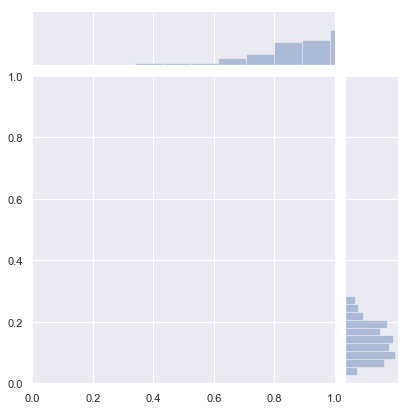

In [90]:

    

    
    
joint_plot_binary(xlabel="f1", ylabel="f2", data=features.features);



In [75]:
pd.concat([features.features, features.labels], axis=1)

f1      f2        f3         f4      f5   Status Broken_Ids
Tap_Id                                                                 
RS01    0.7154  0.1494  3.152997   9.634375  1.5415  WORKING    WORKING
RS02    0.5819  0.1420  3.885832   9.302964  1.6950  WORKING    WORKING
RS03    0.5097  0.1168  3.915020   8.987038  1.3867  WORKING    WORKING
RS04    0.7102  0.1025  4.197384   9.985856  1.4120  WORKING    WORKING
RS05    0.6210  0.1265  3.880482   8.808718  1.3539  WORKING    WORKING
RS06    0.5627  0.1226  4.983466   9.273846  1.5070  WORKING    WORKING
RS07    1.0379  0.1486  3.169115   9.685195  1.8121  WORKING    WORKING
RS08    1.0698  0.2004  3.977511   8.670544  2.0870  WORKING    WORKING
RS09    0.7188  0.1231  3.505230   8.421517  1.9100  WORKING    WORKING
RS10    0.6877  0.1258  2.342276   8.161160  1.0128  WORKING    WORKING
RR01    0.6696  0.1094  4.927345   9.836498  1.8650  WORKING    WORKING
RR02    0.8156  0.0955  5.471779  10.166843  1.9195  WORKING    WORKING
RR03    0.7123  0.1113  4.886730  10.341991  1.9112  WORKING    WORKING
NS01    1.0215  0.2140  3.863674   8.857359  2.3410  WORKING    WORKING
NS02    0.8591  0.1233  7.276339  10.454638  2.0512  WORKING    WORKING
NS03    0.8933  0.1116  3.512896   8.288240  2.0157  WORKING    WORKING
NS04    1.9349  0.2573  2.896701   8.942222  2.4144  WORKING    WORKING
NS05    0.8087  0.1602  3.441884   8.958685  2.0166  WORKING    WORKING
NS06    1.1923  0.2658  3.936827   6.830582  2.5239  WORKING    WORKING
ES01    1.1385  0.1982  3.151622   9.122269  1.9622  WORKING    WORKING
ES02    0.9080  0.1517  4.158313   9.633248  1.8833  WORKING    WORKING
ES03    0.9044  0.1223  4.174423   9.788025  2.0271  WORKING    WORKING
ES04    1.0741  0.1058  4.276609   8.629457  2.0331  WORKING    WORKING
ES05    1.1158  0.1332  3.087300  10.437055  1.7576  WORKING    WORKING
ES06    1.1572  0.1807  3.357221   8.789840  2.1456  WORKING    WORKING
SS01    1.1659  0.1433  2.989549   9.340748  1.9737  WORKING    WORKING
SS02    0.8154  0.1059  4.399627   9.295567  1.8870  WORKING    WORKING
SS03    1.2077  0.1207  4.545562  10.120947  2.3096  WORKING    WORKING
WS01    1.0704  0.1930  2.680193   8.783005  1.8295  WORKING    WORKING
WS02    0.8894  0.0729  6.864984  10.060054  1.8762  WORKING    WORKING
...        ...     ...       ...        ...     ...      ...        ...
RB02x   0.6999  0.0872  3.046781   9.243490  1.4198  WORKING    WORKING
RB03    1.1018  0.0961  2.253912   9.269896  1.3395  WORKING    WORKING
RB04o   1.1927  0.1851  3.494212   9.302814  2.0829  WORKING    WORKING
RB04x   1.1297  0.1516  3.480819   9.444687  1.7331  WORKING    WORKING
RB05o   1.1911  0.0930  4.502448  11.339390  1.7474  WORKING    WORKING
RB05x   0.6322  0.0923  3.084596  11.160202  1.3236  WORKING    WORKING
NA01    0.7680  0.0631  2.940714  10.214509  1.3095  WORKING    WORKING
NA02    0.9912  0.0677  2.785131   9.804841  1.2962  WORKING    WORKING
NA03    0.4662  0.0600  3.182582   8.870665  0.9465  WORKING    WORKING
NA04    0.5080  0.0526  2.695625   9.542088  0.8502  WORKING    WORKING
NA05    0.6453  0.0534  2.683060   9.699906  1.0311  WORKING    WORKING
NA06    1.0448  0.0476  3.860907   9.617009  1.6849  WORKING    WORKING
NA07    1.0108  0.0447  3.573151   9.494559  1.5704  WORKING    WORKING
EA01    1.1353  0.0532  4.328549  12.308390  1.6284  WORKING    WORKING
EA02    0.7813  0.0546  2.940849  10.451772  1.2678  WORKING    WORKING
EA03    0.9037  0.0433  3.511485  11.667191  1.4829  WORKING    WORKING
EA04    0.9984  0.0713  2.858300   9.872163  1.3051  WORKING    WORKING
EA05    0.9351  0.0525  3.117258  10.406616  1.5100  WORKING    WORKING
EA06    0.8552  0.0641  2.618398   9.173477  1.1898  WORKING    WORKING
SA01    1.1722  0.1222  3.980907   8.811052  2.1684  WORKING    WORKING
SA02    0.8884  0.0973  4.170692   9.678212  1.5369  WORKING    WORKING
SA03    0.5608  0.0903  4.925911  10.049020  1.2300  WORKING    WORKING
SA04    0.7700  0.0722  3.380952  10.238055  1.1999 

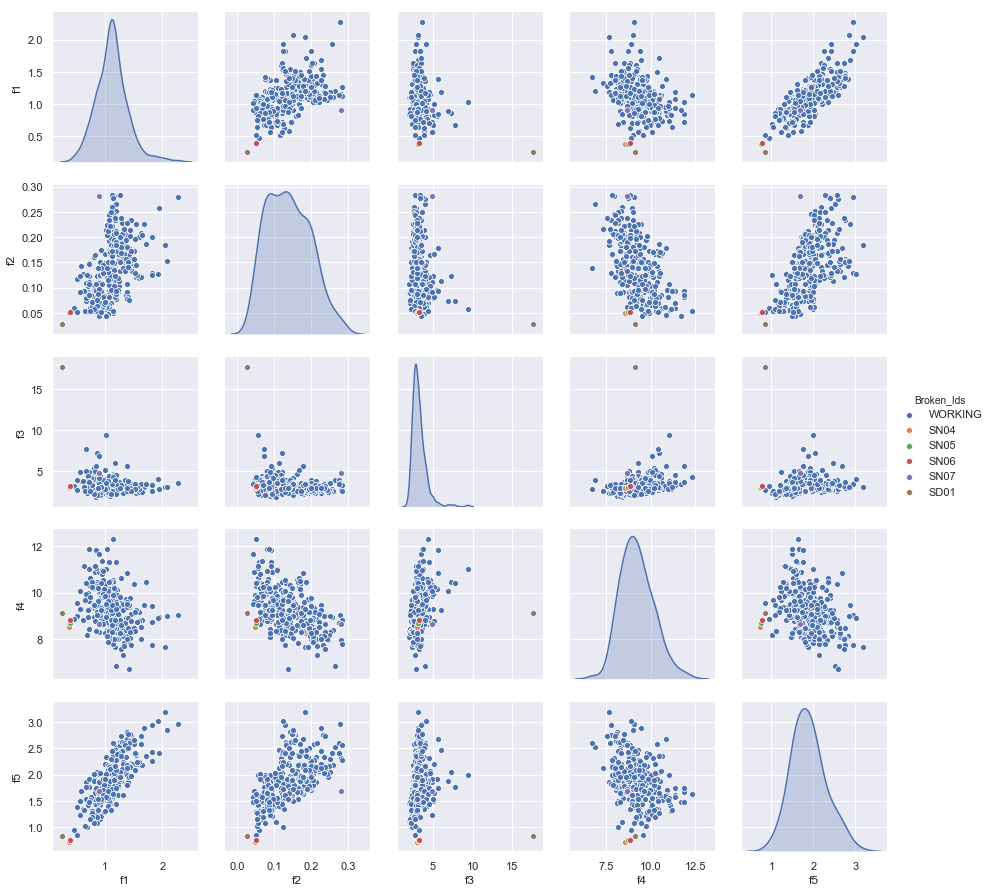

In [76]:
sns.pairplot(pd.concat([features.features, features.labels], axis=1), hue="Broken_Ids");

In [ ]:
features.features.sort_values(by='f1').head()

In [ ]:
features.features.sort_values(by='f2').tail()

In [ ]:
features.features.sort_values(by='f4').head()

zb04 and eb04 seem to be detected by multiple features so lets remove them now to see if we can generalise anything else 


In [ ]:
dfs2 = {key:df.drop(["ZB04", "EB04"]) for key, df in dfs.items()}
features2 = Features(dfs2)

In [ ]:
sns.pairplot(features2.features, hue="labels", kind="reg");

# conclusions

- f4 doesn't seem very good.
- f3 seems ok.
- f2 seems ok as well except it has some false positives.
- f1 sseems ok as well .

more work is needed. lets see if i can get more data 

In [ ]:
for filename in glob.glob('data/*/*' + ext', recursive=True):
    print(filename)

In [ ]:
raw_max